# Introduction to Machine Learning: Supervised Learning
## Final project

## EDA and modelling heart disease information

This notebook contains an exploratory analysis of the *Personal Key Indicators of Heart Disease* dataset from the CDC available on <a href=https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease>Kaggle</a>, the construction of a random forest clasiffier trained to predict if patients reported heart disease in their lifetimes, and an exploration of the resulting model.<br>
Good understanding of factors related to heart disease is of great importance, as it allows to take preventive action and early treatment of heart problems. This notebook is focused on developing a robust model to predict coronary heart disease or myocardial infarction and in understanding the factors related to disease.

More information can be found in the github repository https://github.com/jcazuero94/Intro_to_ML_SL_project

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    make_scorer,
    roc_auc_score,
    RocCurveDisplay,
    plot_confusion_matrix,
    roc_curve,
)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import shap

In [3]:
import warnings

warnings.filterwarnings("ignore")

In [4]:
%matplotlib inline
%load_ext nb_black

<IPython.core.display.Javascript object>

## EDA

Load data

In [5]:
data = pd.read_csv("../Data/heart_2020_cleaned.csv")

<IPython.core.display.Javascript object>

Transform binary and ordinal attributes into integers for analysis and modelling

In [6]:
ser = data["Diabetic"].copy()
data.replace({"Yes": 1, "No": 0}, inplace=True)
data["Diabetic"] = ser

<IPython.core.display.Javascript object>

In [7]:
data["AgeCategory"].unique()

array(['55-59', '80 or older', '65-69', '75-79', '40-44', '70-74',
       '60-64', '50-54', '45-49', '18-24', '35-39', '30-34', '25-29'],
      dtype=object)

<IPython.core.display.Javascript object>

In [8]:
data["AgeCategory"] = data["AgeCategory"].apply(lambda x: int(x[:2]))

<IPython.core.display.Javascript object>

In [9]:
data["GenHealth"].unique()

array(['Very good', 'Fair', 'Good', 'Poor', 'Excellent'], dtype=object)

<IPython.core.display.Javascript object>

In [10]:
data["Sex"].unique()

array(['Female', 'Male'], dtype=object)

<IPython.core.display.Javascript object>

In [11]:
health_map = {"Poor": 0, "Fair": 1, "Good": 2, "Very good": 3, "Excellent": 4}
sex_map = {"Female": 0, "Male": 1}

<IPython.core.display.Javascript object>

In [12]:
data["GenHealth"] = data["GenHealth"].map(health_map)
data["Sex"] = data["Sex"].map(sex_map)

<IPython.core.display.Javascript object>

In [13]:
data.dtypes

HeartDisease          int64
BMI                 float64
Smoking               int64
AlcoholDrinking       int64
Stroke                int64
PhysicalHealth      float64
MentalHealth        float64
DiffWalking           int64
Sex                   int64
AgeCategory           int64
Race                 object
Diabetic             object
PhysicalActivity      int64
GenHealth             int64
SleepTime           float64
Asthma                int64
KidneyDisease         int64
SkinCancer            int64
dtype: object

<IPython.core.display.Javascript object>

In [14]:
data["Race"].unique()

array(['White', 'Black', 'Asian', 'American Indian/Alaskan Native',
       'Other', 'Hispanic'], dtype=object)

<IPython.core.display.Javascript object>

In [15]:
data["Diabetic"].unique()

array(['Yes', 'No', 'No, borderline diabetes', 'Yes (during pregnancy)'],
      dtype=object)

<IPython.core.display.Javascript object>

Data exploration

In [16]:
binary_columns = [
    x for x in data.nunique()[data.nunique() == 2].index if x != "HeartDisease"
]

<IPython.core.display.Javascript object>

In [17]:
binary_columns

['Smoking',
 'AlcoholDrinking',
 'Stroke',
 'DiffWalking',
 'Sex',
 'PhysicalActivity',
 'Asthma',
 'KidneyDisease',
 'SkinCancer']

<IPython.core.display.Javascript object>

In [18]:
data.describe()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
count,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.00000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000
mean,0.085595,28.325399,0.412477,0.068097,0.037740,3.37171,3.898366,0.138870,0.475273,52.440945,0.775362,2.595028,7.097075,0.134061,0.036833,0.093244
std,0.279766,6.356100,0.492281,0.251912,0.190567,7.95085,7.955235,0.345812,0.499389,18.069747,0.417344,1.042918,1.436007,0.340718,0.188352,0.290775
min,0.000000,12.020000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,24.030000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,40.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000
50%,0.000000,27.340000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,55.000000,1.000000,3.000000,7.000000,0.000000,0.000000,0.000000
75%,0.000000,31.420000,1.000000,0.000000,0.000000,2.00000,3.000000,0.000000,1.000000,65.000000,1.000000,3.000000,8.000000,0.000000,0.000000,0.000000
max,1.000000,94.850000,1.000000,1.000000,1.000000,30.00000,30.000000,1.000000,1.000000,80.000000,1.000000,4.000000,24.000000,1.000000,1.000000,1.000000


<IPython.core.display.Javascript object>

In [19]:
column_correlations = data.corr()

<IPython.core.display.Javascript object>

In [20]:
column_correlations["HeartDisease"].sort_values()

GenHealth          -0.243182
PhysicalActivity   -0.100030
AlcoholDrinking    -0.032080
SleepTime           0.008327
MentalHealth        0.028591
Asthma              0.041444
BMI                 0.051803
Sex                 0.070040
SkinCancer          0.093317
Smoking             0.107764
KidneyDisease       0.145197
PhysicalHealth      0.170721
Stroke              0.196835
DiffWalking         0.201258
AgeCategory         0.232325
HeartDisease        1.000000
Name: HeartDisease, dtype: float64

<IPython.core.display.Javascript object>

The atributes that have a greater positive correlation with heart disease are the Age, the difficulty walking and past strokes; while the atributes with greater negative correlation are General health and physical activity.

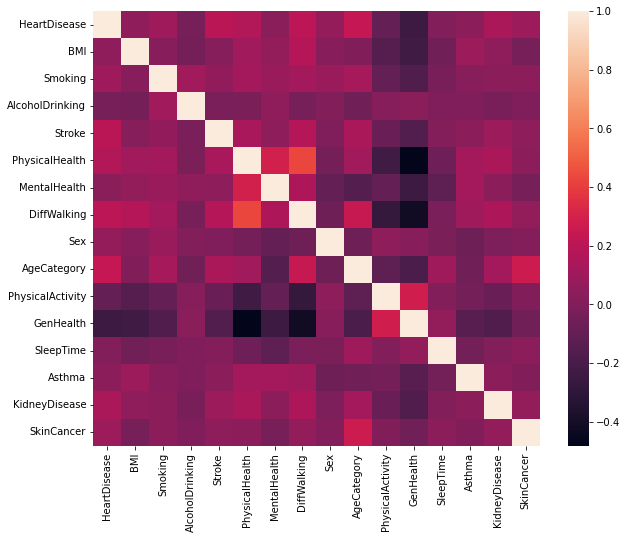

<IPython.core.display.Javascript object>

In [21]:
sns.heatmap(data.corr())
fig = plt.gcf()
fig.set_size_inches(10, 8)

In [21]:
data_plot = data.drop(binary_columns, axis=1)

<IPython.core.display.Javascript object>

In [22]:
sample_plot = data_plot[data_plot["HeartDisease"] == 1].copy()

<IPython.core.display.Javascript object>

In [23]:
sample_plot = pd.concat(
    [
        sample_plot,
        data_plot.loc[
            np.random.choice(
                data_plot[data_plot["HeartDisease"] != 1].index,
                len(sample_plot),
                replace=False,
            )
        ],
    ],
)

<IPython.core.display.Javascript object>

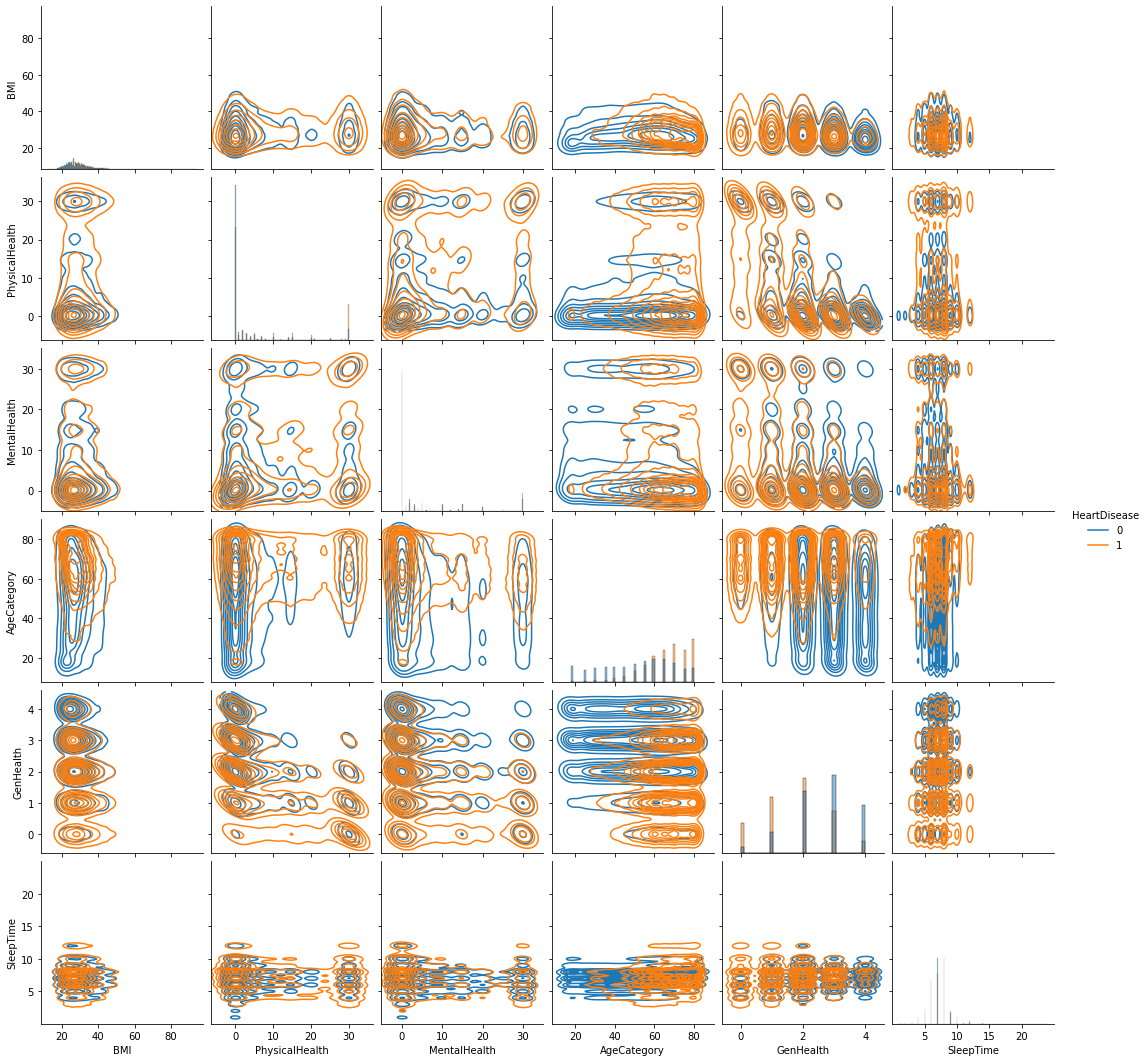

<IPython.core.display.Javascript object>

In [24]:
sns.pairplot(
    sample_plot,
    hue="HeartDisease",
    kind="kde",
    diag_kind="hist",
)

The plot above shows a very clear relation between the possibility of heart disease and other key indicators like age and general health and physical health, 

In [25]:
data[binary_columns + ["HeartDisease"]].groupby("HeartDisease").mean()

,Smoking,AlcoholDrinking,Stroke,DiffWalking,Sex,PhysicalActivity,Asthma,KidneyDisease,SkinCancer
HeartDisease,,,,,,,,,
0,0.396246,0.070569,0.026263,0.117577,0.464572,0.788135,0.129741,0.028466,0.084942
1,0.585869,0.041683,0.160340,0.366346,0.589596,0.638914,0.180214,0.126219,0.181931


<IPython.core.display.Javascript object>

As seen in the table above smoking, previous stroke episodes, difficulty walking, physical activity, Asthma, kidney disease and skin cancer are all related with hearth disease, while alcohol drinking has little incidence.

There seems to be a relation between the incidence of heart disease and the sex of the person as the proportion of men in the dataset with heart disease is greater than the proportion of women. This relation has to be explored further as it may be explained when considering the effect of other variables.

# Modelling

Lets construct some machine learning models to see if we are able to predict hearth disease from the other variables.

In [22]:
data = pd.get_dummies(data, drop_first=True)

<IPython.core.display.Javascript object>

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop("HeartDisease", axis=1), data["HeartDisease"], test_size=0.2
)

<IPython.core.display.Javascript object>

In [24]:
train_ss = pd.DataFrame(
    columns=[x for x in data.columns if x != "HeartDisease"],
    data=StandardScaler().fit_transform(data.drop("HeartDisease", axis=1)),
)

<IPython.core.display.Javascript object>

In [25]:
X_train_ss = train_ss.loc[X_train.index]

<IPython.core.display.Javascript object>

In [26]:
X_test_ss = train_ss.loc[X_test.index]

<IPython.core.display.Javascript object>

In [27]:
def roc_auc_scorer(estimator, X, y):
    return roc_auc_score(y, estimator.predict_proba(X)[:, 1])

<IPython.core.display.Javascript object>

### Logistic regresion

First let's fit a logistic regresion in order to have a baseline model

In [28]:
log_model = LogisticRegression().fit(X_train_ss, y_train)

<IPython.core.display.Javascript object>

In [29]:
print(
    f"Logistic accuracy: {np.mean(cross_val_score(log_model, X_train_ss, y_train, cv=4))}"
)

Logistic accuracy: 0.9158210728748104


<IPython.core.display.Javascript object>

In [30]:
print(
    f"Logistic ROC AUC: {np.mean(cross_val_score(log_model, X_train_ss, y_train, cv=4, scoring=roc_auc_scorer))}"
)

Logistic ROC AUC: 0.8404060735215327


<IPython.core.display.Javascript object>

In [43]:
coefs_log = (
    pd.DataFrame(
        index=list(X_train_ss.columns),
        columns=["Coef"],
        data=log_model.coef_.T,
    )
    .sort_values("Coef")
    .reset_index()
)

<IPython.core.display.Javascript object>

In [50]:
coefs_log.loc[
    coefs_log["Coef"].apply(lambda x: abs(x)).sort_values(ascending=False).index
].head()

,index,Coef
22,AgeCategory,0.980381
0,GenHealth,-0.520062
21,Sex,0.348751
20,Stroke,0.199082
19,Smoking,0.176382


<IPython.core.display.Javascript object>

The baseline logistic regresion model achieves a 92% accuracy and a roc auc score of 0.84 in the validation set. The most important attribues according to the coefficient norm are Age category, general health, sex, and stroke and smoking history.

### Random Forest

Now let's try with a random forest to see if we can improve the achieved results

In [30]:
imbalance_factor = 1 / data["HeartDisease"].mean()

<IPython.core.display.Javascript object>

In [31]:
def gen_rf_hyperparameters():
    n_estimators = max(int(10 ** (np.random.random() * 1.5 + 1)), 1)
    max_depth = np.random.choice([1, 2, 5, 10, 20])
    min_samples_leaf = np.random.randint(1, 100)
    class_weight = {0: 1, 1: (np.random.random() + 1) * imbalance_factor}
    max_features = np.random.random()
    return {
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "min_samples_leaf": min_samples_leaf,
        "class_weight": class_weight,
        "max_features": max_features,
    }

<IPython.core.display.Javascript object>

### Cross validation

Now the hyperparameters for the model are going to be selected through 50 iterations of cross-validation.

In [32]:
n_cv = 50

<IPython.core.display.Javascript object>

In [33]:
score = 0.5
final_params_allcols = None

<IPython.core.display.Javascript object>

In [34]:
for i in range(n_cv):
    if i % 5 == 0:
        print(
            f"Iteration {i+1} - {n_cv}: CV - {datetime.datetime.today().strftime('%H:%M:%S')}"
        )
    params = gen_rf_hyperparameters()
    model = RandomForestClassifier(**params)
    cv_score = np.mean(
        cross_val_score(
            model,
            X_train,
            y_train,
            cv=4,
            scoring=roc_auc_scorer,
        )
    )
    if cv_score > score:
        score = cv_score
        final_params_allcols = params
        print(f"Iter {i} - ROC AUC score :{score}")

Iteration 1 - 50: CV - 15:55:31
Iter 0 - ROC AUC score :0.8027481045921633
Iter 1 - ROC AUC score :0.8304528096551451
Iter 4 - ROC AUC score :0.8324311949141636
Iteration 6 - 50: CV - 15:56:32
Iter 5 - ROC AUC score :0.8384203626875769
Iter 8 - ROC AUC score :0.8393541990919462
Iteration 11 - 50: CV - 16:02:09
Iter 13 - ROC AUC score :0.8411070736527291
Iteration 16 - 50: CV - 16:03:23
Iteration 21 - 50: CV - 16:04:20
Iteration 26 - 50: CV - 16:06:03
Iteration 31 - 50: CV - 16:08:07
Iteration 36 - 50: CV - 16:12:21
Iter 36 - ROC AUC score :0.842111168781905
Iteration 41 - 50: CV - 16:14:53
Iteration 46 - 50: CV - 16:16:53


<IPython.core.display.Javascript object>

The AUC ROC cross-validated score is similar to the one of the logistic regresion, just a little bit higher. Now, feature selection will be developed to see if the resulting model can be improved.

### Feature selection

In order to do feature selection the Boruta method will be used. This method trains multiple models on the dataset including permutations of columns and does a statistical test based on the feature importances of the attribute and its permutation, in order to select which attributes have predictive power. Further information about Boruta can be found in the <a href=https://danielhomola.com/boruta_py>documentation</a>.

In [40]:
bor_iter = 5
columns_to_retain = set()
for i in range(bor_iter):
    print(
        f"Iteration {i+1} - {bor_iter}: Boruta - {datetime.datetime.today().strftime('%H:%M:%S')}"
    )
    params = gen_rf_hyperparameters()
    model = RandomForestClassifier(**params)
    boruta = BorutaPy(estimator=model, n_estimators="auto", max_iter=100)
    boruta.fit(
        np.array(X_train),
        np.array(y_train),
    )
    columns_to_retain = columns_to_retain.union(
        X_train.columns[boruta.support_].to_list()
    )
    if len(columns_to_retain) == len(X_train.columns):
        print(f"All columns were found important")
        break
print(f"Columns to retain: {columns_to_retain}")

Iteration 0 - 5: Boruta - 16:28:15
Iteration 1 - 5: Boruta - 16:32:10
Iteration 2 - 5: Boruta - 17:12:41
Iteration 3 - 5: Boruta - 17:13:19
Iteration 4 - 5: Boruta - 17:24:40
Columns to retain: {'Smoking', 'GenHealth', 'AgeCategory', 'Race_White', 'Stroke', 'SleepTime', 'SkinCancer', 'DiffWalking', 'MentalHealth', 'KidneyDisease', 'PhysicalActivity', 'BMI', 'Diabetic_Yes', 'PhysicalHealth', 'Sex'}


<IPython.core.display.Javascript object>

In [41]:
score = 0.5
final_params = None

<IPython.core.display.Javascript object>

In [42]:
for i in range(n_cv):
    if i % 5 == 0:
        print(
            f"Iteration {i+1} - {n_cv}: CV - {datetime.datetime.today().strftime('%H:%M:%S')}"
        )
    params = gen_rf_hyperparameters()
    model = RandomForestClassifier(**params)
    cv_score = np.mean(
        cross_val_score(
            model,
            X_train[columns_to_retain],
            y_train,
            cv=4,
            scoring=roc_auc_scorer,
        )
    )
    if cv_score > score:
        score = cv_score
        final_params = params
        print(f"Iter {i} - ROC AUC score :{score}")

Iteration 1 - 50: CV - 17:36:35
Iter 0 - ROC AUC score :0.8359097760211274
Iter 1 - ROC AUC score :0.8393963752946834
Iteration 6 - 50: CV - 17:37:25
Iter 7 - ROC AUC score :0.8395562376428167
Iteration 11 - 50: CV - 17:38:48
Iteration 16 - 50: CV - 17:44:24
Iter 15 - ROC AUC score :0.8412336362704519
Iteration 21 - 50: CV - 17:47:18
Iteration 26 - 50: CV - 17:48:15
Iteration 31 - 50: CV - 17:49:33
Iteration 36 - 50: CV - 17:53:05
Iteration 41 - 50: CV - 17:55:45
Iteration 46 - 50: CV - 18:01:53


<IPython.core.display.Javascript object>

The model has a similar ROC AUC score as the logistic regresion model and the random forest with all features. Feature selection is usefull as it allows to produce a simpler model with similar predictive power.<br>
In this case I would recomend to stick with the logistic regresion as it is simpler and much more explainable. In order to overcome the lesser explainability of models like random forest, there have been developed tools like shapely additive values which we will now explore.

In [43]:
model_rf = RandomForestClassifier(**final_params)

<IPython.core.display.Javascript object>

In [44]:
model_rf.fit(X_train[columns_to_retain], y_train)

RandomForestClassifier(class_weight={0: 1, 1: 16.446937105618545}, max_depth=10,
                       max_features=0.29989989212796664, min_samples_leaf=45,
                       n_estimators=153)

<IPython.core.display.Javascript object>

#### SHAP

Let's use Shapely Additive values to explore feature importance and contribution. This methodology allows to estimate the marginal contribution of each feature for every prediction. More information about the topic is available <a href=https://christophm.github.io/interpretable-ml-book/shapley.html>here</a>.

In [45]:
explainer = shap.TreeExplainer(model_rf)

<IPython.core.display.Javascript object>

In [46]:
shap_values = explainer.shap_values(X_test[columns_to_retain], y_test)

<IPython.core.display.Javascript object>

The following plot shows the shapely values which can interpreted as the marginal contribution towards the prediction for each record attribute of the test set. One point in the following graph in the AgeCategory column represents a single observation whose AgeCategory value is encoded in the color (so older people are red dots), and has the marginal contribution calculated plotted in the x-axis. An easier way to interpret the graph is by understanding the width of the point cloud as the feature importance and by knowing that if red points are on the right of the plot, then there is a positive correlation between the feature and heart disease, and viceversa.

This plot shows that the most important factors contributing to the risk of heart disease are age and general well beign, followed by sex, diabetes, dificulty walking, previous stroke episodes and smoking.

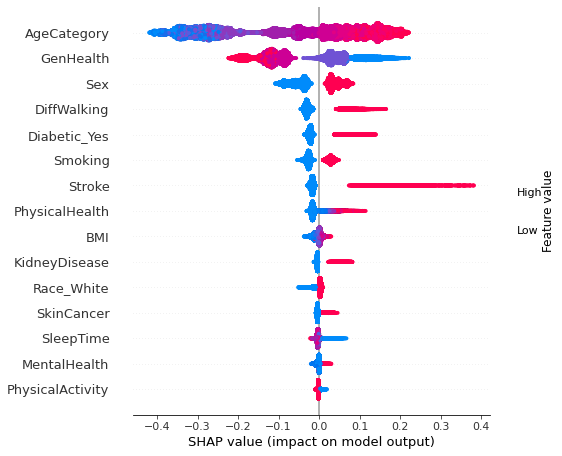

<IPython.core.display.Javascript object>

In [47]:
shap.summary_plot(shap_values[1], X_test[columns_to_retain])

## Metrics

Now let's evaluate the performance of the models by plotting the resulting ROC curves and confusion matrices.

In [48]:
y_test_pred_proba = model_rf.predict_proba(X_test[columns_to_retain])

<IPython.core.display.Javascript object>

In [49]:
y_test_pred_proba_log = log_model.predict_proba(X_test_ss)

<IPython.core.display.Javascript object>

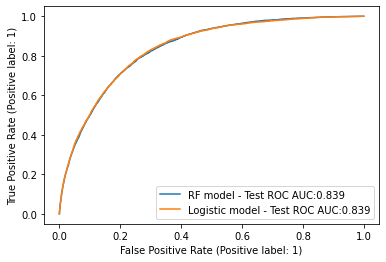

<IPython.core.display.Javascript object>

In [53]:
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(
    y_test,
    y_test_pred_proba[:, 1],
    ax=ax,
    label=f"RF model - Test ROC AUC:{round(roc_auc_score(y_test, y_test_pred_proba[:, 1]),3)}",
)
RocCurveDisplay.from_predictions(
    y_test,
    y_test_pred_proba_log[:, 1],
    ax=ax,
    label=f"Logistic model - Test ROC AUC:{round(roc_auc_score(y_test, y_test_pred_proba_log[:, 1]),3)}",
)

Both models, the logistic regresion and the random forest achieve considerable predictive power. The confusion matrix shown below is evidence of the utility of the model as they can identify high risk individuals so that preventive measures can be taken.

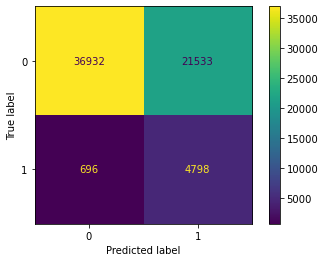

<IPython.core.display.Javascript object>

In [56]:
plot_confusion_matrix(model_rf, X_test[columns_to_retain], y_test)